# Jet Tagging with **Conv2D** 

**Objective**: Jet identification task using a Conv2D multiclass classifier.
The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100
bins of a square window of the ($\eta$, $\phi$) plane, centered along the jet axis.

### Date: Jun 20, 2021 
### Shivam Verma

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# importing kera
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, Flatten
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

# Preparating the training and validation data

In [3]:
target = np.array([])
jetImage = np.array([])
datafiles = ['Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           'Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'Data/JetDataset/jetImage_7_100p_0_10000.h5']
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myjetImage = np.array(f.get("jetImage"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, jetImage.shape)

Appending Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data/JetDataset/jetImage_7_100p_0_10000.h5
(30000, 5) (30000, 100, 100)


### Train:Test = 75:25

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetImage, target, test_size=0.25)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetImage, target

(22500, 100, 100) (7500, 100, 100) (22500, 5) (7500, 5)


Reshaping the training dataset since in keras  images are representable as $n \times m \times k$ tensors, where $n \times m$ are the pixel dimenions and $k$ is the number of channels (e.g., 1 in a black $\&$ while image, 3 for an RGB image). In our case, $k=1$. To comply to this, we add the channel index by reshaping the image dataset

In [5]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(22500, 100, 100, 1) (7500, 100, 100, 1) (22500, 5) (7500, 5)


# Conv 2D model building

In [7]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
dropoutRate = 0.25

In [9]:
image_shape = (img_rows, img_cols, 1)
#
inputImage = Input(shape=(image_shape))
x = Conv2D(5, kernel_size=(5,5), data_format="channels_last", strides=(1, 1), padding="same")(inputImage)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (5,5))(x)
x = Dropout(dropoutRate)(x)
#
x = Conv2D(3, kernel_size=(3,3), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (3,3))(x)
x = Dropout(dropoutRate)(x)
#
x = Flatten()(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
#
model = Model(inputs=inputImage, outputs=output)

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 5)       130       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 5)       20        
_________________________________________________________________
activation (Activation)      (None, 100, 100, 5)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 5)         0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 20, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 3)         138   

### Model training begins

In [10]:
batch_size = 128
n_epochs = 2

In [13]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/2
176/176 - 151s - loss: 1.4189 - val_loss: 1.3105
Epoch 2/2
176/176 - 151s - loss: 1.3632 - val_loss: 1.2733


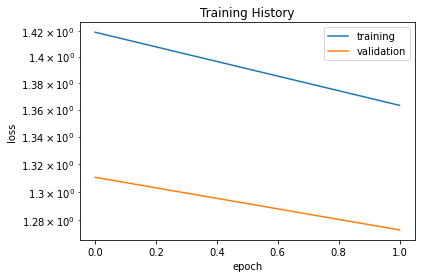

In [14]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

In [15]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

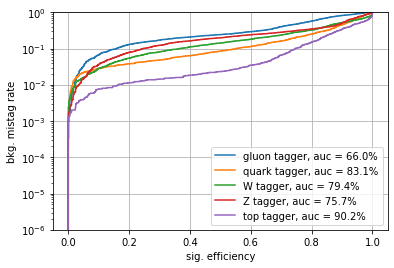

In [16]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()